In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import skimage as ski
import os
from ipywidgets import interact


https://stackoverflow.com/questions/6090399/get-hog-image-features-from-opencv-python

In [2]:
def imshow(img):
    b, g, r = cv2.split(img)
    return cv2.merge((r, g, b))

def rg_chrom(img):
    '''assumes bgr im and makes rg chromic'''
    B, G, R = cv2.split(img)
    B = np.float32(B)
    G = np.float32(G)
    R = np.float32(R)

    RBG = R + B + G
    RBG[RBG == 0] = 1
    r = R/(RBG)
    g = G/(RBG)
    b = (B/(RBG))

    return r, g, b

def show_channels(img, noreturn=True):
    '''load a colour image and return the colour, greyscale and r,g,b channels'''
    
    B, G, R = cv2.split(img)
    grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    RGB = cv2.merge((R, G, B))
    r, g, b = rg_chrom(img)
    rgb = cv2.merge((R, G, B))
    HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(HSV)
    
    fig, ax = plt.subplots(3, 4)
    fig.set_size_inches(10,10)
    fig.tight_layout()
    ax[0, 0].set_title('RGB')
    ax[0, 0].imshow(RGB)
#     ax[0, 1].set_title('greyscale')
#     ax[0, 1].imshow(grey , cmap='gray')
    ax[0, 1].set_title('Red')
    ax[0, 1].imshow(R, cmap='gray')
    ax[0, 2].set_title('Green')
    ax[0, 2].imshow(G, cmap='gray')
    ax[0, 3].set_title('Blue')
    ax[0, 3].imshow(B, cmap='gray')
    
    ax[1, 0].set_title('rgb')
    ax[1, 0].imshow(rgb)
    ax[1, 1].set_title('red')
    ax[1, 1].imshow(r, cmap='gray')
    ax[1, 2].set_title('green')
    ax[1, 2].imshow(g, cmap='gray')
    ax[1, 3].set_title('blue')
    ax[1, 3].imshow(b, cmap='gray')
    
    ax[2, 0].set_title('HSV')
    ax[2, 0].imshow(HSV)
    ax[2, 1].set_title('H')
    ax[2, 1].imshow(H, cmap='gray')
    ax[2, 2].set_title('S')
    ax[2, 2].imshow(S, cmap='gray')
    ax[2, 3].set_title('V')
    ax[2, 3].imshow(V, cmap='gray')


    for a in ax.flatten():
        a.set_xticks([])
        a.set_yticks([])
        a.set_xticklabels([])
        a.set_yticklabels([])
    
    if not noreturn:
        return fig, ax
    
def thresh_bradley_roth(img, s=None, t=None):
    '''
    https://stackoverflow.com/questions/33091755/bradley-roth-adaptive-thresholding-algorithm-how-do-i-get-better-performance

    The function takes in three parameters: the grayscale image image, the size
    of the window s and the threshold t. This threshold is different than what
    you have as this is following the paper exactly. The threshold t is a per-
    centage of the total summed area of each pixel window. If the summed area is
    less than this threshold, then the output should be a black pixel - else it's
    a white pixel. The defaults for s and t are the number of columns divided by
    8 and rounded, and 15% respectively

    '''

    # convert to greyscale if colour
    if len(img.shape) == 3:
        raise ValueError('input image should be in greyscale')

    # Default window size is round(cols/8)
    if s is None:
        s = np.int16(np.round(img.shape[1] / 8))

    # Default threshold is 15% of the total
    # area in the window
    if t is None:
        t = 15.0

    # Compute integral image
    intImage = np.cumsum(np.cumsum(img, axis=1), axis=0)

    # Define grid of points
    (rows, cols) = img.shape[:2]
    (X, Y) = np.meshgrid(np.arange(cols, dtype=np.int16), np.arange(rows, dtype=np.int16))

    # Make into 1D grid of coordinates for easier access
    X = X.ravel()
    Y = Y.ravel()

    # Ensure s is even so that we are able to index into the image
    # properly
    s = s + np.mod(s, 2)

    # Access the four corners of each neighbourhood
    s2 = np.floor_divide(s, 2)
    x1 = X - s2
    x2 = X + s2
    y1 = Y - s2
    y2 = Y + s2

    # Ensure no coordinates are out of bounds
    x1[x1 < 0] = 0
    x2[x2 >= cols] = cols - 1
    y1[y1 < 0] = 0
    y2[y2 >= rows] = rows - 1

    # Count how many pixels are in each neighbourhood
    count = (x2 - x1) * (y2 - y1)

    # Compute the row and column coordinates to access
    # each corner of the neighbourhood for the integral image
    f1_x = x2
    f1_y = y2
    f2_x = x2
    f2_y = y1 - 1
    f2_y[f2_y < 0] = 0
    f3_x = x1 - 1
    f3_x[f3_x < 0] = 0
    f3_y = y2
    f4_x = f3_x
    f4_y = f2_y

    # Compute areas of each window
    sums = intImage[f1_y, f1_x] - intImage[f2_y, f2_x] - intImage[f3_y, f3_x] + intImage[f4_y, f4_x]

    # Compute thresholded image and reshape into a 2D grid
    out = np.ones(rows * cols, dtype=np.bool)
    out[img.ravel() * count <= sums * (100.0 - t) / 100.0] = False

    # Also convert back to uint8
    out = 255 * np.reshape(out, (rows, cols)).astype(np.uint8)

    return out


In [3]:
PATH = r'/home/patrick/ml-data/equipment-photos/equipment-photos'
PLP_PATH = os.path.join(PATH, 'plp')
image_paths = [os.path.join(PLP_PATH, plp) for plp in os.listdir(PLP_PATH)]

In [7]:
UM = cv2.imread(image_paths[0])
PM = cv2.imread(image_paths[1])
SM = cv2.imread(image_paths[2])

In [8]:
show_channels(UM)

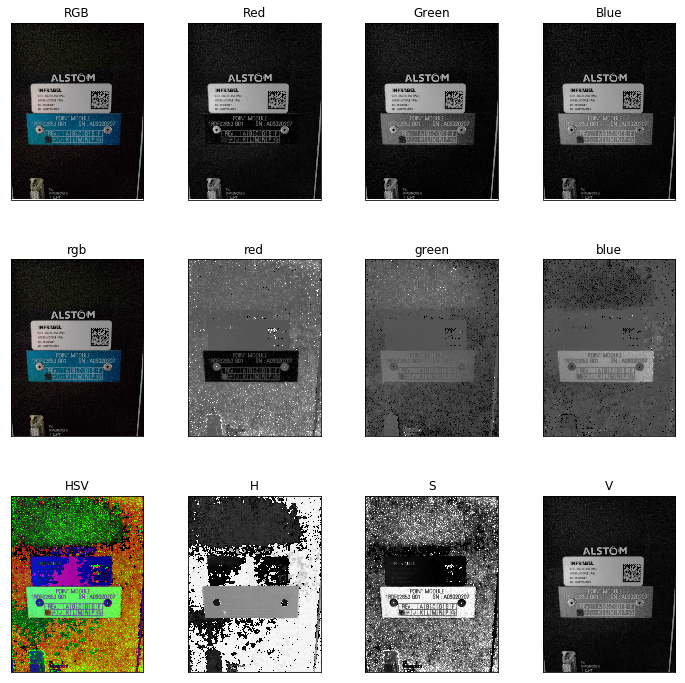

In [9]:
show_channels(PM)

In [10]:
show_channels(SM)

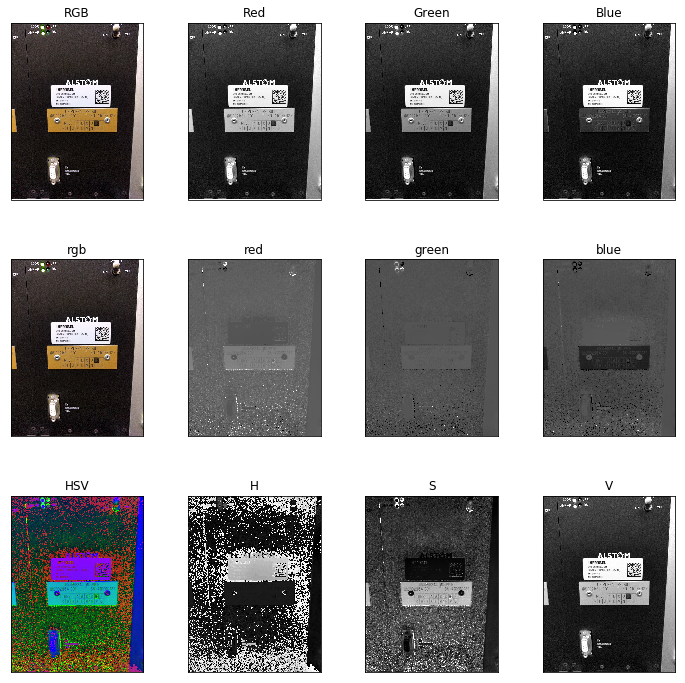

In [105]:
img = cv2.imread(image_paths[7])
show_channels(img)

In [167]:
h,s,v = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
r,g,b = rg_chrom(img)

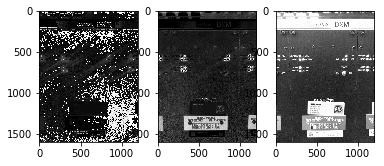

In [169]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(h, cmap='gray')
ax[1].imshow(s, cmap='gray')
ax[2].imshow(v, cmap='gray')

fig, ax = plt.subplots(1, 3)
ax[0].imshow(r, cmap='gray')
ax[1].imshow(g, cmap='gray')
ax[2].imshow(b, cmap='gray')

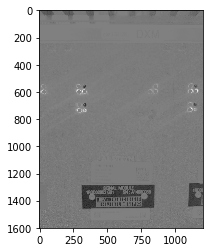

In [170]:
plt.imshow(g-r, cmap='gray')

In [175]:
a = g-r

In [166]:
plt.imshow(b-g)

In [172]:
def foo(s, t):
    plt.imshow(thresh_bradley_roth(g-r, s=s, t=t), cmap='gray')
    
interact(foo, s=(0,30,2), t=(0,30,2))

interactive(children=(IntSlider(value=14, description='s', max=30, step=2), IntSlider(value=14, description='t', max=30, step=2), Output()), _dom_classes=('widget-interact',))

<function __main__.foo>

In [179]:
a

array([[-0.05147061, -0.05959031, -0.0848861 , ..., -0.03541315,
        -0.03559321, -0.03304347],
       [-0.04578754, -0.05008945, -0.06928837, ..., -0.03236797,
        -0.03220338, -0.03253424],
       [-0.03797469, -0.04561403, -0.05594406, ..., -0.03204048,
        -0.03204048, -0.03236797],
       ..., 
       [-0.09271523, -0.06410256, -0.01769909, ...,  0.        ,
        -0.01612902, -0.04761904],
       [-0.12025318, -0.08917198, -0.08547008, ..., -0.03252032,
        -0.06896549, -0.10294116],
       [-0.1342282 , -0.12056737, -0.10526314, ..., -0.0625    ,
        -0.09154931, -0.12666667]], dtype=float32)

In [190]:
plt.imshow(np.abs(250*a), cmap='gray')

In [184]:
np.max(a)

1.0

## HOG testjes

In [191]:

image = cv2.imread(image_paths[7],0)

winSize = (64,64)
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64
hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma,
                        histogramNormType, L2HysThreshold, gammaCorrection,nlevels)
#compute(img[, winStride[, padding[, locations]]]) -> descriptors
winStride = (8,8)
padding = (8,8)
locations = ((10,20),)
hist = hog.compute(image,winStride,padding,locations)

In [193]:
hist.shape

(1764, 1)

In [194]:
plt.plot(hist)

## skimage

In [196]:
from skimage.feature import hog, hessian_matrix, local_binary_pattern
import skimage.io as skio

In [277]:
img = skio.imread(image_paths[7], as_grey=True)
img

array([[ 0.31087451,  0.30024863,  0.2725298 , ...,  0.99215686,
         0.99215686,  0.99215686],
       [ 0.18676824,  0.21675686,  0.27196431, ...,  0.99215686,
         0.99215686,  0.99215686],
       [ 0.27696431,  0.32599529,  0.34338588, ...,  0.98823529,
         0.99215686,  0.99607843],
       ..., 
       [ 0.05914471,  0.06922784,  0.09021176, ...,  0.44296392,
         0.46649333,  0.48610118],
       [ 0.07067216,  0.04769333,  0.07093216, ...,  0.42922706,
         0.43568627,  0.47882353],
       [ 0.05330431,  0.07492196,  0.09590588, ...,  0.46059961,
         0.4729298 ,  0.46508667]])

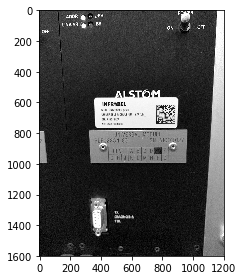

In [202]:
skio.imshow(img)

In [207]:
h = hog(img, block_norm='L2-Hys', visualise=True,)

# image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), 
# block_norm='L1', visualise=False, transform_sqrt=False, feature_vector=True, normalise=None)

C:\Users\EXK478\AppData\Local\Continuum\Miniconda3\envs\ML\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


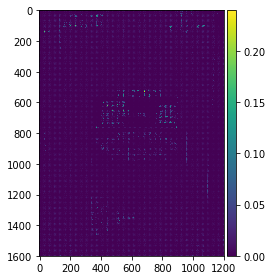

In [211]:
skio.imshow(h[1])

winSize = (64,64)  
blockSize = (16,16)  
blockStride = (8,8)  
cellSize = (8,8)  
nbins = 9  
derivAperture = 1  
winSigma = 4.  
histogramNormType = 0  
L2HysThreshold = 2.0000000000000001e-01  
gammaCorrection = 0  
nlevels = 64  

In [247]:
# P : int
#     Number of circularly symmetric neighbour set points (quantization of the angular space).
# R : float
#     Radius of circle (spatial resolution of the operator).
img_eq = ski.exposure.equalize_hist(img, nbins=256, mask=None)
lbp = local_binary_pattern(img_eq, 10, 30)
skio.imshow(lbp)

C:\Users\EXK478\AppData\Local\Continuum\Miniconda3\envs\ML\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


In [248]:
plt.imshow(lbp, cmap='gray')

In [234]:
lbp.shape

(1600, 1200)

In [246]:
skio.imshow(ski.exposure.equalize_hist(img, nbins=256, mask=None))

In [268]:
skio.imshow(ski.filters.threshold_niblack(img))

C:\Users\EXK478\AppData\Local\Continuum\Miniconda3\envs\ML\lib\site-packages\skimage\filters\thresholding.py:777: RuntimeWarning: invalid value encountered in sqrt
  s = np.sqrt(g2 - m * m)
C:\Users\EXK478\AppData\Local\Continuum\Miniconda3\envs\ML\lib\site-packages\numpy\lib\function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


## Contour

In [279]:
img_int = np.array(255*img).astype(np.int8)

In [402]:
def thresh_otsu(image_path):
    img = skio.imread(image_path)
    hsv = ski.color.rgb2hsv(img)
    s = hsv[:,:,1]
    thresh = ski.filters.threshold_otsu(s)
    threshed_image = np.where(s > thresh, 255, 0)
    plt.imshow(threshed_image, cmap='gray')
    plt.show()
    
    return threshed_image.astype(np.uint8)


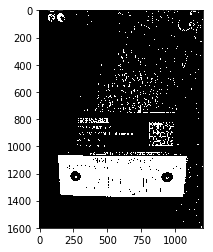

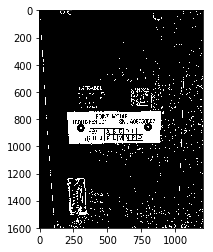

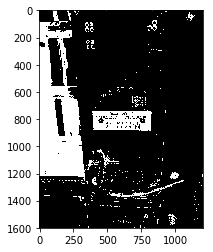

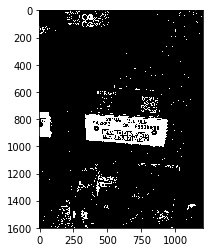

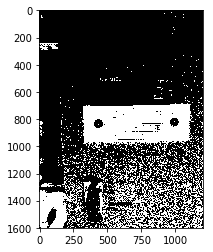

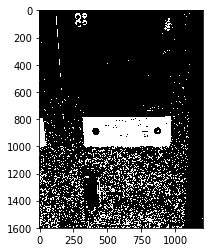

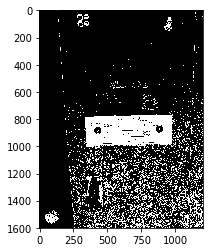

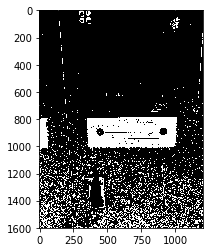

In [403]:
for image_path in image_paths[:10]:
    thresh_otsu(image_path)
    

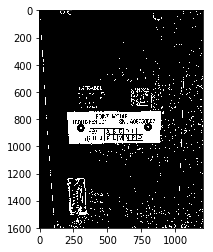

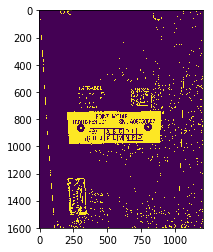

In [404]:
img = thresh_otsu(image_paths[1])
plt.imshow(img)

In [405]:
img.dtype

dtype('uint8')

## Contouren

In [406]:
img

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ..., 
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0, 255, 255]], dtype=uint8)

In [412]:
from skimage import measure
from skimage import morphology

In [410]:
cont = measure.find_contours(img, level=250)
len(cont)

13422

In [396]:
cont[2]

array([[   0.        ,  154.60784314],
       [   0.60784314,  154.        ],
       [   1.        ,  153.60784314],
       [   1.60784314,  153.        ],
       [   2.        ,  152.60784314],
       [   3.        ,  152.60784314],
       [   4.        ,  152.60784314],
       [   5.        ,  152.60784314],
       [   6.        ,  152.60784314],
       [   6.60784314,  152.        ],
       [   7.        ,  151.60784314],
       [   8.        ,  151.60784314],
       [   9.        ,  151.60784314],
       [  10.        ,  151.60784314],
       [  10.39215686,  152.        ],
       [  11.        ,  152.60784314],
       [  12.        ,  152.60784314],
       [  13.        ,  152.60784314],
       [  14.        ,  152.60784314],
       [  14.39215686,  153.        ],
       [  15.        ,  153.60784314],
       [  16.        ,  153.60784314],
       [  17.        ,  153.60784314],
       [  17.39215686,  154.        ],
       [  18.        ,  154.60784314],
       [  19.        ,  1

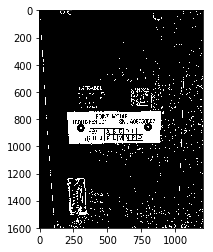

In [415]:
plt.imshow(img, cmap='gray')

http://scikit-image.org/docs/dev/user_guide/tutorial_segmentation.html

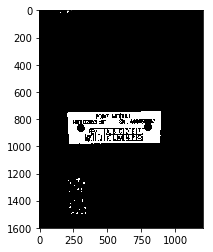

In [468]:
opened = morphology.binary_opening(img, selem=morphology.disk(4))
opened = morphology.binary_opening(img, selem=morphology.disk(4))

plt.imshow(opened, cmap='gray')

In [442]:
contours = measure.find_contours(opened, level=0)

In [469]:
fig, ax = plt.subplots()
ax.imshow(opened, cmap='gray')

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], lw=2)

In [440]:
rect = max(contours, key=len)

In [443]:
plt.plot(rect[:,1], rect[:,0])

In [436]:
# find contour corners

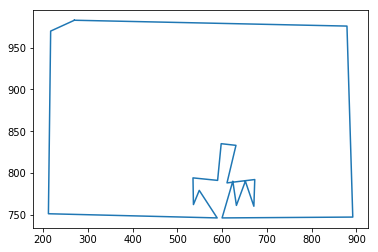

In [471]:
cont_approx = measure.subdivide_polygon(rect)
cont_approx = measure.approximate_polygon(rect, tolerance=20)
plt.plot(cont_approx[:,1], cont_approx[:,0])

In [473]:
cv2.boundingRect(rect)

error: C:\bld\opencv_1498174012660\work\opencv-3.2.0\modules\imgproc\src\shapedescr.cpp:466: error: (-215) npoints >= 0 && (depth == CV_32F || depth == CV_32S) in function cv::pointSetBoundingRect


In [490]:
im, c, h = cv2.findContours(np.where(opened, 255, 0).astype(np.uint8),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

list

In [495]:
a = np.array([1,2,3])
b = np.array([3,4,5])

In [496]:
a@b

26